In [1]:
import matplotlib
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.art3d as art3d

import pandas as pd

import os
import os.path as osp

import numpy as np


from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Circle
%matplotlib inline

In [2]:
def readArray(text):
    return np.fromstring(text[1:-1], sep=' ')

In [3]:
err_treshold = 10

In [4]:
target_points = np.loadtxt('../src/test_points.txt')

In [5]:
com0_points = np.full((len(target_points),3),[-0.01303,  0.00229,  0.25252])

In [6]:
optim1 = pd.read_csv('../fddp_optimization/scripts/test_optim_1ms.csv',header=0)

In [7]:
optim2 = pd.read_csv('../fddp_optimization/scripts/test_optim_2ms.csv',header=0)


In [8]:
# avg optimization time with 1ms, and 2ms discr.
optim1['elapsed_time'].mean(), optim2['elapsed_time'].mean()

(4.224481437817093, 2.2346291249777)

In [9]:
optim1.rel_landing_error.mean(), optim2.rel_landing_error.mean()

(0.3519002186166725, 0.3810070160216035)

In [10]:
tests = [12000,25000,50000,75000,100000, 'optim2','optim1']

In [11]:
def_model = 256

In [12]:
data_path = "../"

## Volumetric plot of feasible target

In [13]:
cmap=plt.cm.jet
norm = matplotlib.colors.Normalize(vmin=0, vmax=err_treshold)

In [14]:
tests_error = []

125
191
249
261
316
118
168


/tmp/ipykernel_198822/3949367297.py:95: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


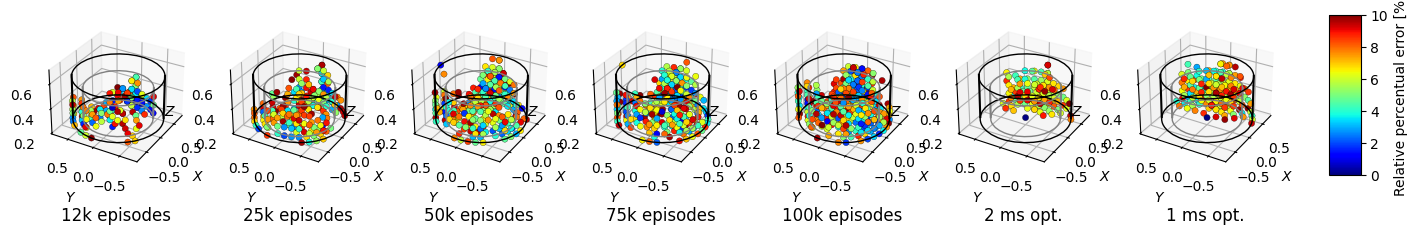

In [15]:
fig = plt.figure(figsize=plt.figaspect(1/len(tests)))

for i, test in enumerate(tests):
    # check if the test result is a model run
    if str(test).isnumeric():
        # load csv wiht test results
        dt = pd.read_csv(
            osp.join(data_path, f'runs_TD3_{def_model}', 'test', f'model_{test}', 'test.csv'))
        
        # compute performance
        com0_points = np.vstack(dt.state.apply(readArray).to_numpy())[:, :3]
        reached_points = np.vstack(dt.next_state.apply(readArray).to_numpy())[:, :3]

        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
    
    elif test == 'optim1':
        perc_error = optim1.rel_landing_error.to_numpy().copy()

    elif test == 'optim2':
        perc_error = optim2.rel_landing_error.to_numpy().copy()


    # common calulcation
    perc_error*=100
    tests_error.append(perc_error)
    # Filter points with perc_error < err_treshold
    idx = perc_error <= err_treshold
    err_filter = perc_error[idx]
    feasible_region = target_points[idx, :]
    n_of_point = len(err_filter)
    print(n_of_point)

    # add the volumetric plot
    ax = fig.add_subplot(1, len(tests), i+1, projection='3d')

    ax.margins(x=0,y=0,z=0)
    ax.set_xlim(-.79, .79)
    ax.set_ylim(-.79, .79)
    ax.set_zlim(0.2, .7)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    ax.set_zlabel('$Z$')
    ax.view_init(azim=-150,elev=30)
    feasible_plot = ax.scatter(feasible_region[:, 0], feasible_region[:, 1], feasible_region[:, 2],
                                    c=err_filter, alpha=1, edgecolors="black", linewidths=0.2,
                                    cmap=cmap, norm=norm)

    # train region
    r = 0.6
    top = Circle( (0, 0),r, fill = False, color='grey')
    down = Circle( (0, 0),r, fill = False, color='grey')
    ax.add_patch(top)
    ax.add_patch(down)
    art3d.pathpatch_2d_to_3d(top, z=0.25, zdir="z")
    art3d.pathpatch_2d_to_3d(down, z=0.5, zdir="z")

    x0 = r * np.cos(-np.pi/2+0.5)
    y0 = r * np.sin(-np.pi/2+0.5)

    x1 = r * np.cos(np.pi/2+0.5)
    y1 = r * np.sin(np.pi/2+0.5)

    plt.plot([x0,x0],[y0,y0],[0.25,0.5], color='gray',zorder=2.5)
    plt.plot([x1,x1],[y1,y1],[0.25,0.5], color='gray',zorder=2.5)
    
    # test region
    r = 0.78
    top = Circle( (0, 0),r, fill = False, color='black')
    down = Circle( (0, 0),r, fill = False, color='black')
    ax.add_patch(top)
    ax.add_patch(down)
    art3d.pathpatch_2d_to_3d(top, z=0.25, zdir="z")
    art3d.pathpatch_2d_to_3d(down, z=0.6, zdir="z")

    x0 = r * np.cos(-np.pi/2+0.5)
    y0 = r * np.sin(-np.pi/2+0.5)

    x1 = r * np.cos(np.pi/2+0.5)
    y1 = r * np.sin(np.pi/2+0.5)

    plt.plot([x0,x0],[y0,y0],[0.25,0.6], color='black',zorder=2.5)
    plt.plot([x1,x1],[y1,y1],[0.25,0.6], color='black',zorder=2.5)
       
    if 'optim' not in str(test):
        ax.set_title( f'{int(test/1000)}k episodes', y=.0, pad=-35)
    else:
        ax.set_title( f'{str(test)[-1]} ms opt.', y=.0, pad=-35)
    
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])
fig.colorbar(feasible_plot, shrink=0.3, label='Relative percentual error [%]', cax=cbar_ax)
# fig.suptitle('Target positions with RPE $\leq$ 0.1')
fig.savefig(os.path.join('plots', f'feasible_filtered.pdf'), dpi=500, bbox_inches='tight')
fig.show()

### Counting plot

In [16]:
# Define colors for yellow, green, and their blend
colors = [(1, 0.6, 0), (1, 0.8, 0), (1, 1, 0), (0.4, 1, 0), (0, 0.7, 0)]

# Create a custom colormap with linear interpolation
n_jmp_cmap = LinearSegmentedColormap.from_list('custom_cmap', colors, N=6)  # N=6 for 1 to 6

/tmp/ipykernel_198822/8213361.py:78: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


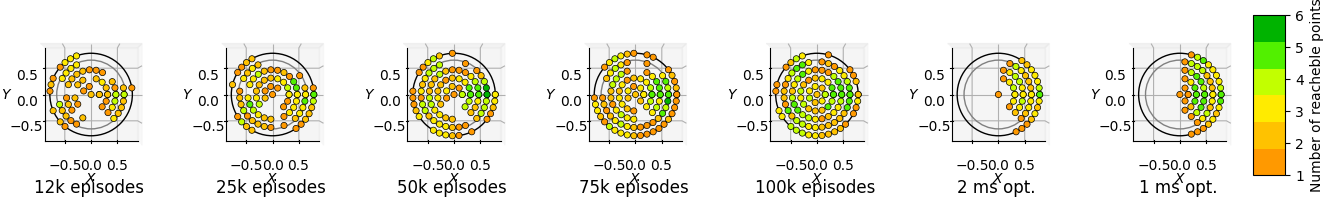

In [18]:
fig = plt.figure(figsize=plt.figaspect(1/len(tests)))

for i, test in enumerate(tests):
    # check if the test result is a model run
    if str(test).isnumeric():
        # load csv wiht test results
        dt = pd.read_csv(
            osp.join(data_path, f'runs_TD3_{def_model}', 'test', f'model_{test}', 'test.csv'))
        
        # compute performance
        com0_points = np.vstack(dt.state.apply(readArray).to_numpy())[:, :3]
        reached_points = np.vstack(dt.next_state.apply(readArray).to_numpy())[:, :3]

        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance
    
    elif test == 'optim1':
        perc_error = optim1.rel_landing_error.to_numpy().copy()

    elif test == 'optim2':
        perc_error = optim2.rel_landing_error.to_numpy().copy()

    # common calulcation
    perc_error*=100
    # Filter points with perc_error < err_treshold
    idx = perc_error <= err_treshold
    err_filter = perc_error[idx]
    feasible_region = target_points[idx, :]
    n_of_point = len(err_filter)

    # generate surface
    xy_pair = []
    err = []

    for j,p in enumerate(feasible_region):
        # new point
        if [p[0],p[1]] not in xy_pair:
            xy_pair.append([p[0],p[1]])
            err.append([err_filter[j]])
        else:
            # x,y present, get if z > z in array
            idx = xy_pair.index([p[0],p[1]])
            err[idx].append(err_filter[j])

    nr_points = [len(e) for e in err]
    surface = np.append(np.array(xy_pair),np.array(nr_points).reshape(-1,1),axis=1)

    ax = fig.add_subplot(1, len(tests), i+1, projection='3d',computed_zorder=False)
    train_area = Circle( (0, 0),0.65, fill = False, color='gray')
    test_area = Circle( (0, 0),0.78, fill = False, color='black')
    ax.add_patch(test_area)
    ax.add_patch(train_area)
    art3d.pathpatch_2d_to_3d(train_area, z=0, zdir="z")
    art3d.pathpatch_2d_to_3d(test_area, z=0, zdir="z")
    ax.margins(x=0,y=0,z=0)
    ax.set_xlim(-.85, .85)
    ax.set_ylim(-.85, .85)
    # ax.set_zlim(0, 0.7)
    ax.zaxis.line.set_lw(0.)
    ax.set_zticks([])
    ax.view_init(azim=-90,elev=90)
    ax.set_xlabel('$X$')
    ax.set_ylabel('$Y$')
    
    if 'optim' not in str(test):
        ax.set_title( f'{int(test/1000)}k episodes', y=.0, pad=-15)
    else:
        ax.set_title( f'{str(test)[-1]} ms opt.', y=.0, pad=-15)

    surf_plot = ax.scatter(surface[:, 0], surface[:, 1], 0, alpha=1, edgecolors="black", linewidths=0.5, c=surface[:, 2], cmap=n_jmp_cmap, vmin=1, vmax=6)

cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
fig.colorbar(surf_plot, shrink=0.3, label='Number of reacheble points', cax=cbar_ax)

# fig.suptitle('Mean RPE fo test target positions [RPE $\leq$ 0.1]')
fig.savefig(os.path.join('plots', f'numb_points_surface_plot.pdf'), dpi=500, bbox_inches='tight')
fig.show()

### Performance on front and back juimpg

In [19]:
back_index = (target_points[:,0] <= 0) & (np.linalg.norm(target_points[:,:2],axis=-1) <= 0.63) & (target_points[:,2] <= 0.53)

In [20]:
front_index = (target_points[:,0] >= 0) & (np.linalg.norm(target_points[:,:2],axis=-1) <= 0.63) & (target_points[:,2] <= 0.53)

In [21]:
tests_error = np.array(tests_error)

In [22]:
tests_error.shape

(7, 726)

In [23]:
err_256_opt_bk = tests_error[... , back_index].mean(axis=1)
err_256_opt_bk

array([42.91854538, 31.20910716, 25.64341799, 24.38313438, 19.2479739 ,
       60.09118383, 55.64187894])

In [35]:
err_256_opt_fr = tests_error[... , front_index].mean(axis=1)
err_256_opt_fr

array([42.9721747 , 27.41591594, 20.65604527, 18.74324698, 16.98942969,
       21.14284907, 18.69061669])

In [36]:
tests_error_128 = []

In [37]:
for i, test in enumerate([12000,25000,50000,75000,100000]):
    # check if the test result is a model run
    if str(test).isnumeric():
        # load csv wiht test results
        dt = pd.read_csv(
            osp.join(data_path, f'runs_TD3_128', 'test', f'model_{test}', 'test.csv'))
        
        # compute performance
        com0_points = np.vstack(dt.state.apply(readArray).to_numpy())[:, :3]
        reached_points = np.vstack(dt.next_state.apply(readArray).to_numpy())[:, :3]

        target_error = np.linalg.norm(target_points - reached_points, axis=1)
        target_distance = np.linalg.norm(target_points-com0_points, axis=1)
        perc_error = target_error/target_distance

    # common calulcation
    perc_error*=100
    tests_error_128.append(perc_error)

In [38]:
tests_error_128 = np.array(tests_error_128)

In [39]:
tests_error_128.shape

(5, 726)

In [40]:
err_128_bk = tests_error_128[... , back_index].mean(axis=1)
err_128_bk

array([41.69650874, 32.22611338, 21.69210086, 18.33417141, 16.68141254])

In [41]:
err_128_fr = tests_error_128[... , front_index].mean(axis=1)
err_128_fr

array([45.98185412, 28.07587761, 28.20077561, 18.83083956, 18.9056001 ])

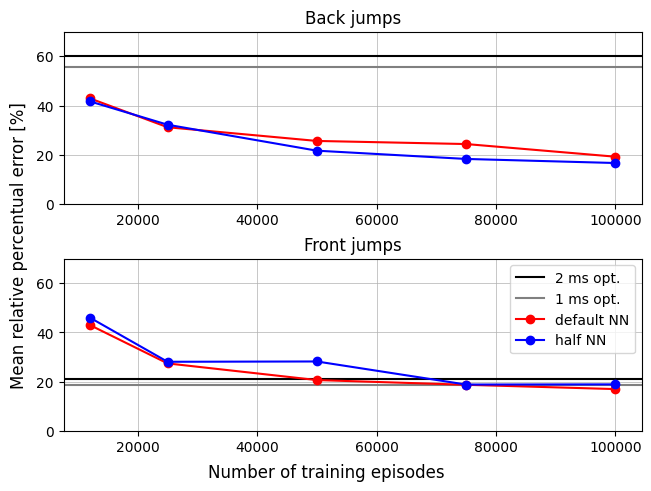

In [42]:
fig, (ax1, ax2) = plt.subplots(2, 1, layout='constrained', sharey=True)

# back jump
ax1.set_ylim(0, 70)

ax1.axhline(err_256_opt_bk[-2], color='black', label='2 ms opt.')
ax1.axhline(err_256_opt_bk[-1], color='gray', label='1 ms opt.')

ax1.plot(tests[:-2], err_256_opt_bk[:-2],
         '-o', color='red', label="default NN")

ax1.plot(tests[:-2], err_128_bk,
         '-o', color='blue', label="half NN")

ax1.grid(linewidth=0.5)

ax1.set_title('Back jumps')

# front jump
ax2.set_ylim(0, 70)

ax2.axhline(err_256_opt_fr[-2], color='black', label='2 ms opt.')
ax2.axhline(err_256_opt_fr[-1], color='gray', label='1 ms opt.')

ax2.plot(tests[:-2], err_256_opt_fr[:-2],
         '-o', color='red', label="default NN")

ax2.plot(tests[:-2], err_128_fr,
         '-o', color='blue', label="half NN")

ax2.grid(linewidth=0.5)

ax2.set_title('Front jumps')
ax2.grid(linewidth=0.5)
ax2.legend()


fig.supxlabel('Number of training episodes')
fig.supylabel('Mean relative percentual error [%]')
plt.savefig(os.path.join('plots', 'jumps_avg_error.pdf'), dpi=500,  bbox_inches='tight')
plt.show()